In [ ]:
from wandb.keras import WandbCallback
import sys
import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from utils.utils_mine import *
import tensorflow as tf
import tensorflow.keras as keras
from datetime import date
import numpy as np
import random
import tensorflow_addons as tfa
import wandb
import gc
from classifiers.classifier_factory import create_classifier
from scripts.plot.DL.read_LOO_nestedCV_gnntr import get_sorted_loo_array
import tensorflow as tf
import subprocess
# pylint: disable = attribute-defined-outside-init, no-name-in-module, unexpected-keyword-arg
# pylint: disable = no-value-for-parameter
from tensorflow.python.ops import state_ops as tf_state_ops
# import pingouin as pg 

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [10]:
fold = 'allData/RawData/Baseline_fnirs/Patients'
os.listdir(fold)
subject_name = [i[:5] for i in os.listdir(fold) if i[:2] == 'PT']
subject_name = list(subject_name)
subject_name = list(set(subject_name))
for name in subject_name:
    if name[-3:] == '036':
        print(name)

len(subject_name)

PT036


70

In [44]:
result = 'results/ML_results/simple_prediction/clinical_data_modality_classification/ten_repeat_nested_cv.npy'
result = np.load(result, allow_pickle=True)
result = result.item()
# for key, value in result.items():
#     print(key)
#     print(value)
#     print('--------------------------------------')
classifiers_name = list(result[0]['external_result'].keys())
metrics = list(result[0]['external_result'][classifiers_name[0]].keys())

avg_inner_result = {classifier_name: {metric: [] for metric in metrics} for classifier_name in classifiers_name}
avg_external_result = {classifier_name: {metric: [] for metric in metrics} for classifier_name in classifiers_name}


for classifier in classifiers_name:
    for metric in metrics:

        avg_inner_result[classifier][metric] = [result[i]['inner_result'][classifier][metric] for i in range(10)]
        avg_external_result[classifier][metric] = [result[i]['external_result'][classifier][metric] for i in range(10)]

print("\n## Inner Cross-Validation Performance")
print("| Classifier | Average bAcc | Average Sensitivity | Average Specificity | Average F1 Score |")
print("|------------|-----------------|------------------|---------------------|---------------------|")
for name, metrics in avg_inner_result.items():
    avg_metrics = {metric: np.mean(scores) for metric, scores in metrics.items()}
    print(f"| {name} | {avg_metrics['balanced accuracy']:.4f} | {avg_metrics['sensitivity']:.4f} | {avg_metrics['specificity']:.4f} | {avg_metrics['f1 score']:.4f} |")

print("\n## Outer Cross-Validation Performance")
print("| Classifier | Average bAcc | Average Sensitivity | Average Specificity | Average F1 Score |")
print("|------------|-----------------|------------------|---------------------|---------------------|")
for name, metrics in avg_external_result.items():
    avg_metrics = {metric: np.mean(scores) for metric, scores in metrics.items()}

    print(f"| {name} | {avg_metrics['balanced accuracy']:.4f} | {avg_metrics['sensitivity']:.4f} | {avg_metrics['specificity']:.4f} | {avg_metrics['f1 score']:.4f} |")
                                                    
                                                   


## Inner Cross-Validation Performance
| Classifier | Average bAcc | Average Sensitivity | Average Specificity | Average F1 Score |
|------------|-----------------|------------------|---------------------|---------------------|
| SVM | 0.4072 | 0.4036 | 0.4108 | 0.2267 |
| XGBoost | 0.5250 | 0.4318 | 0.6182 | 0.3032 |
| Naive Bayes | 0.4376 | 0.7052 | 0.1700 | 0.3037 |

## Outer Cross-Validation Performance
| Classifier | Average bAcc | Average Sensitivity | Average Specificity | Average F1 Score |
|------------|-----------------|------------------|---------------------|---------------------|
| SVM | 0.2929 | 0.2857 | 0.3000 | 0.1509 |
| XGBoost | 0.5043 | 0.4286 | 0.5800 | 0.2927 |
| Naive Bayes | 0.4843 | 0.9286 | 0.0400 | 0.3467 |


: 

In [18]:
classifiers_name

['SVM', 'XGBoost', 'Naive Bayes']

In [17]:
result[0]['inner_result']['SVM']

{'balanced accuracy': 0.4072395833333333,
 'sensitivity': 0.40364583333333326,
 'specificity': 0.4108333333333333,
 'f1 score': 0.22672896547896548}

In [13]:
[i for i in range(10) for j in range(10)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9]

In [10]:
mddr_pth = 'allData/prognosis_mix_hb/pretreatment_response/MDDR/MDDR_derived_from_load_evaluate.npy'
label_pth = 'allData/prognosis_mix_hb/pretreatment_response/label.npy'

mddr = np.load(mddr_pth)
label = np.load(label_pth)
print(mddr.shape)

# Extract the predictions for the second output dimension
y_scores = mddr[..., 1].flatten()
y_true = label.flatten()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


(10, 64, 2)


ValueError: Found input variables with inconsistent numbers of samples: [64, 640]

In [2]:
label_pth = 'allData/prognosis_mix_hb/pretreatment_response/label.npy'
label = np.load(label_pth)
print(label)

response_pth = 'allData/prognosis_mix_hb/pretreatment_response/label_hamd.npy'
response = np.load(response_pth)
response = (response[:, 1] - response[:, 0]) / response[:, 0]
print(response)
# np.save('allData/prognosis_mix_hb/pretreatment_response/label_reduce_percentage.npy', response)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
[-0.24       -0.33333333 -0.25925926 -0.25        0.58823529  0.5
  0.13333333  0.38095238 -0.13636364 -0.19047619 -0.28571429 -0.23809524
  0.52631579 -0.06666667 -0.56521739 -0.38095238  0.         -0.44444444
 -0.4         0.26315789 -0.66666667 -0.36       -0.86363636 -0.33333333
 -0.43333333 -0.76       -0.5        -0.16666667 -0.42307692 -0.25
 -0.04347826  0.125      -0.25       -0.25       -0.08333333 -0.08
 -0.36363636 -0.04761905 -0.6875     -0.5483871  -0.03846154 -0.56521739
  0.          0.16666667 -0.13043478 -0.61904762  0.06666667 -0.71428571
 -0.56521739 -0.34615385  0.33333333  0.63157895 -0.375       0.6
 -0.125      -0.5        -0.53846154 -0.17647059  0.14285714  0.5
 -1.          0.         -0.25       -0.31578947]


In [11]:
parameter = {'label_pathx': 'xxxlabel.npy'}
label_pth = parameter.get('label_path', 'label.npy')
label_pth

'label.npy'

sub: 8, k: 4, indx_max: 0
loss            39.555698
accuracy         0.480769
val_loss        38.915871
val_accuracy     0.818182
lr               0.000000
Name: 0, dtype: float64
sub: 21, k: 4, indx_max: 0
loss            39.624126
accuracy         0.673077
val_loss        38.984299
val_accuracy     0.818182
lr               0.000000
Name: 0, dtype: float64
sub: 36, k: 3, indx_max: 0
loss            39.655571
accuracy         0.461538
val_loss        39.015739
val_accuracy     0.909091
lr               0.000000
Name: 0, dtype: float64
sub: 36, k: 4, indx_max: 0
loss            39.532921
accuracy         0.384615
val_loss        38.893089
val_accuracy     0.636364
lr               0.000000
Name: 0, dtype: float64
sub: 41, k: 3, indx_max: 0
loss            39.691719
accuracy         0.490196
val_loss        39.093712
val_accuracy     0.666667
lr               0.000000
Name: 0, dtype: float64
sub: 43, k: 0, indx_max: 0
loss            39.515278
accuracy         0.423077
val_loss        3

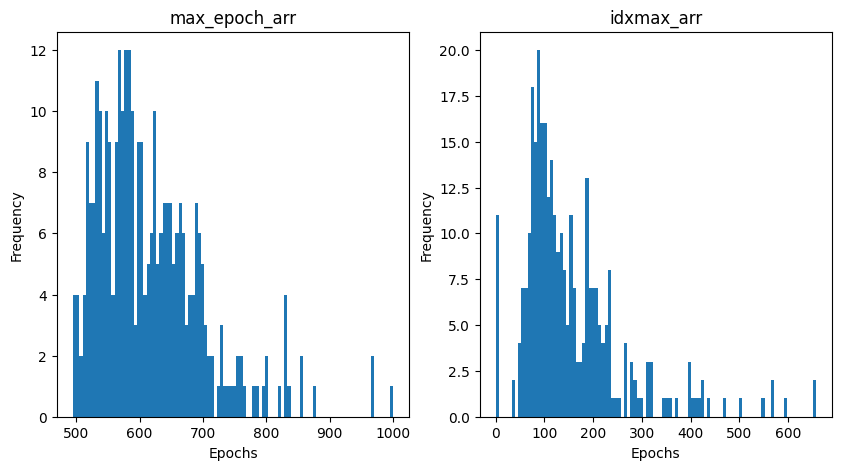

In [12]:
from scripts.result_analysis.model_analysis import model_result
import os
import pandas as pd
import matplotlib.pyplot as plt




show_max_epoch_idxmax(main_path = 'results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v4l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/LOO_')



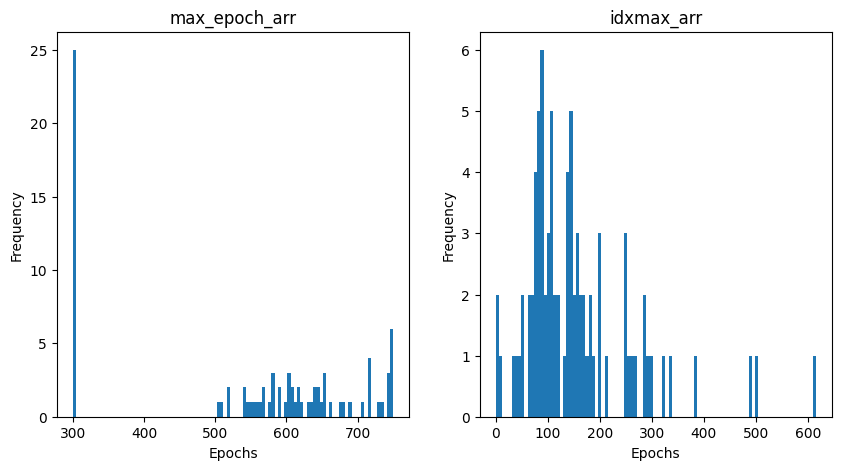

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

max_epoch_arr = []
idxmax_arr = []

main_path = 'results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/LOO_'

TOTAL_SUBJECT = 64
NUM_OF_K_FOLD = 5 
history_file_name = 'history.csv'
best_model_based_metric = 'val_accuracy'
inner_fold_name = 'stratified_nested_5_CV_fold-'

for sub in range(TOTAL_SUBJECT):
    for k in range(NUM_OF_K_FOLD):
        fold_path = main_path + str(sub) + '/' + inner_fold_name + str(k)
        file_path = fold_path + '/' + history_file_name
        if os.path.exists(file_path):
            res = pd.read_csv(file_path)
            max_index = len(res[best_model_based_metric]) # 
            indx_max = res[best_model_based_metric].idxmax()
            max_epoch_arr.append(max_index)
            idxmax_arr.append(indx_max)
            
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(max_epoch_arr, bins=100)
axs[0].set_title('max_epoch_arr')
axs[1].hist(idxmax_arr, bins=100)
axs[1].set_title('idxmax_arr')
for i in range(2):
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Frequency')

653

Text(0.5, 1.0, 'idxmax_arr')

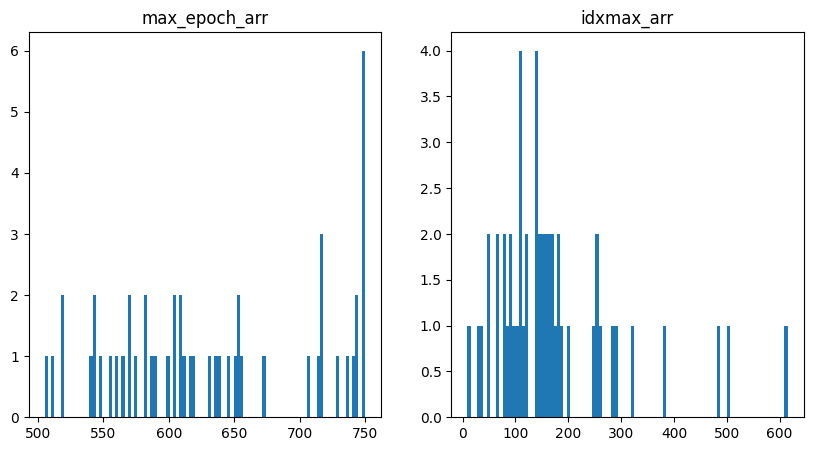

In [4]:
merge_psychiatry_demo = np.load('allData/prognosis_mix_hb/pretreatment_response/merge_psychiatry_demo_dose_data.npy')
print(merge_psychiatry_demo.shape)

x2 = np.load('allData/prognosis_mix_hb/pretreatment_response/nor_demo_cli_merge_data.npy')
print(x2.shape)

(64, 10)
(64, 17)


: 

In [2]:
# calculate feature and apply SVM/XGBoost to see the performance

# 1. load the data
input_fold = 'allData/prognosis_mix_hb/pretreatment_response'
data = np.load(input_fold + '/hb_data.npy')
label = np.load(input_fold + '/label.npy')

print(data.shape)
HbO = data[...,0::2] # np.transpose(data[...,0::2],(0,2,1))
# HbO = individual_normalization(HbO)
print(f'HbO: {HbO.shape}')
HbR = data[...,1::2] # np.transpose(data[...,1::2],(0,2,1))
HbT = HbO + HbR

data = np.concatenate((HbO,HbR,HbT),axis=-1)


(64, 52, 2500)
HbO: (64, 52, 1250)


configs/pretreatment_response_cv_5_hbo.py

python ./LOO_nested_CV_train.py cnn_gnn_transformer loocv_v0 pretreatment_response_cv_5_hbo

In [9]:
for i in range(20):
    command = f'python scripts/plot/DL/read_LOO_nestedCV_gnntr.py --max 4 --K_FOLD 5 --result_path results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v{i}l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6'.split(' ')
    result = subprocess.run(command, capture_output=True, text=True)
    print(command)
    print(result.stdout)

['python', 'scripts/plot/DL/read_LOO_nestedCV_gnntr.py', '--max', '4', '--K_FOLD', '5', '--result_path', 'results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6']
val_fold_path results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/LOO_0
num_of_cv_folds 5
y_test [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
MAX_ITR: 4 ranging ( 2 ~ 3 )
Model name: gnn_transformer_with_cli_demo
specify_itr None
value_add_to_sensitivity_value 0.0
| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|----

In [7]:
command

['python',
 'scripts/plot/DL/read_LOO_nestedCV_gnntr.py',
 '--max',
 '4',
 '--K_FOLD',
 '5',
 '--result_path',
 'results/gnn_transformer_with_cli_demo/prognosis_mix_hb/pretreatment_response/loocv_v0l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6']

In [3]:
y_pred_all = np.load('results/gnn_transformer/prognosis_mix_hb/pretreatment_response/ten-fold-evaluate/y_pred_test_all.npy')
print(y_pred_all.shape)
np.save('allData/prognosis_mix_hb/pretreatment_response/MDDR/MDDR_derived_from_load_evaluate.npy', y_pred_all)

(10, 64, 2)


: 

In [60]:
a = [0,1,1,0,0,0,1]
a_one_hot = tf.one_hot(a, 2)

freq_accumulator = tf.reduce_sum(a_one_hot, axis=0, keepdims=True)
freq_comparator = tf.tile(freq_accumulator, [2, 1])
print('freq_accumulator', freq_accumulator)
print('transpose freq_accumulator', tf.transpose(freq_accumulator))
print('freq_comparator', freq_comparator)
mask = tf.cast(
            tf.greater(tf.transpose(freq_accumulator), freq_comparator),
            dtype=tf.float32,
        )

freq_accumulator tf.Tensor([[4. 3.]], shape=(1, 2), dtype=float32)
transpose freq_accumulator tf.Tensor(
[[4.]
 [3.]], shape=(2, 1), dtype=float32)
freq_comparator tf.Tensor(
[[4. 3.]
 [4. 3.]], shape=(2, 2), dtype=float32)


In [61]:
long_tail = freq_comparator / tf.transpose(freq_accumulator)
p_factor = 0.8
mitigator = (long_tail ** p_factor) * mask + (1-mask)
mitigator_factor = tf.gather(mitigator, tf.argmax(a_one_hot, axis=-1))
mitigator_factor

<tf.Tensor: shape=(7, 2), dtype=float32, numpy=
array([[1.        , 0.79441786],
       [1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 0.79441786],
       [1.        , 0.79441786],
       [1.        , 0.79441786],
       [1.        , 1.        ]], dtype=float32)>

In [58]:
# _get_compensation_factor

q_factor = 2.0

labels = a_one_hot

logits = tf.constant([[0.56, 0.44], [0.6, 0.4], [0.45, 0.55], [0.66, 0.34], [0.7, 0.3], [0.1, 0.9], [0.45, 0.55]])

scores = tf.math.softmax(logits, axis=-1)

gt_label = tf.argmax(labels, axis=1)

indices = tf.stack(
            [tf.range(0, tf.shape(logits)[0], dtype=gt_label.dtype), gt_label], axis=1
        )

cls_score = tf.gather_nd(scores, indices)
argmax_logits = tf.argmax(logits, axis=-1) == gt_label
compensator = scores / tf.expand_dims(cls_score, axis=-1)
mask = tf.cast(tf.greater(compensator, 1.0), dtype=labels.dtype)
compensation_factor = (compensator ** q_factor) * mask + (1 - mask)
print('compensation_factor', compensation_factor)

compensation_factor tf.Tensor(
[[1.        1.       ]
 [1.4918244 1.       ]
 [1.        1.       ]
 [1.        1.       ]
 [1.        1.       ]
 [1.        4.9530325]
 [1.        1.       ]], shape=(7, 2), dtype=float32)


In [62]:
seesaw_weights = tf.ones_like(labels, dtype=tf.float32)
seesaw_weights *= mitigator_factor 
seesaw_weights = seesaw_weights * compensation_factor
print('seesaw_weights', seesaw_weights)


seesaw_weights tf.Tensor(
[[1.         0.79441786]
 [1.4918244  1.        ]
 [1.         1.        ]
 [1.         0.79441786]
 [1.         0.79441786]
 [1.         3.9347775 ]
 [1.         1.        ]], shape=(7, 2), dtype=float32)


In [67]:
print(seesaw_weights)
print(1-labels)
print((1-labels) * seesaw_weights)

tf.Tensor(
[[1.         0.79441786]
 [1.4918244  1.        ]
 [1.         1.        ]
 [1.         0.79441786]
 [1.         0.79441786]
 [1.         3.9347775 ]
 [1.         1.        ]], shape=(7, 2), dtype=float32)
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(7, 2), dtype=float32)
tf.Tensor(
[[0.         0.79441786]
 [1.4918244  0.        ]
 [1.         0.        ]
 [0.         0.79441786]
 [0.         0.79441786]
 [0.         3.9347775 ]
 [1.         0.        ]], shape=(7, 2), dtype=float32)


: 

In [4]:
data = np.load('allData/prognosis/pretreatment_response/hb_data.npy')
data.shape

(64, 52, 2500)

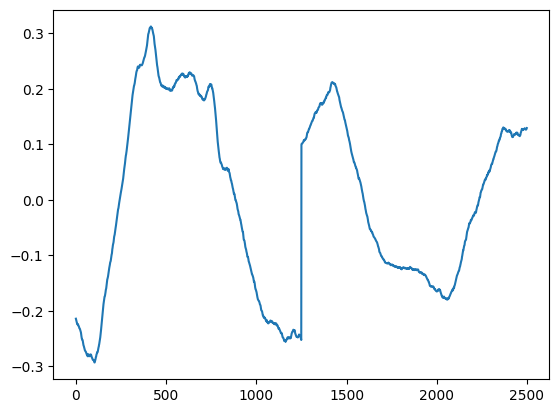

In [5]:
plt.plot(np.mean(data, axis=(0, 1)))

In [7]:
a = np.arange(10)

shuffled_indices = np.random.permutation(a.shape[0])
print(shuffled_indices)

original = [shuffled_indices.tolist().index(i) for i in range(10)]
shuffle_back = shuffled_indices[original]

print(shuffle_back)

[3 4 6 0 9 7 5 1 2 8]
[0 1 2 3 4 5 6 7 8 9]


In [3]:
data = np.load('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/results/his_metrics.npy', allow_pickle=True)
print(data)

{'fprs': [array([0.  , 0.02, 0.04, 0.08, 0.14, 0.18, 0.18, 0.18, 0.22, 0.28, 0.36,
       0.4 , 0.4 , 0.44, 0.44, 0.5 , 0.5 , 0.52, 0.6 , 0.62, 0.7 , 0.7 ,
       0.72, 0.72, 0.74, 0.74, 0.84, 0.92, 0.96, 0.96, 1.  ]), array([0.  , 0.02, 0.08, 0.08, 0.14, 0.14, 0.34, 0.34, 0.36, 0.36, 0.38,
       0.38, 0.4 , 0.4 , 0.48, 0.48, 0.54, 0.54, 0.64, 0.64, 0.7 , 0.74,
       0.82, 0.82, 0.84, 0.84, 1.  ]), array([0.  , 0.04, 0.68, 0.68, 0.68, 0.68, 0.68, 0.76, 0.82, 0.82, 1.  ]), array([0.  , 0.02, 0.06, 0.1 , 0.14, 0.28, 0.32, 0.36, 0.44, 0.48, 0.48,
       0.5 , 0.54, 0.62, 0.68, 0.68, 0.7 , 0.74, 0.78, 0.9 , 0.9 , 0.96,
       1.  ]), array([0.  , 0.02, 0.12, 0.16, 0.24, 0.24, 0.26, 0.3 , 0.36, 0.36, 0.4 ,
       0.4 , 0.46, 0.46, 0.48, 0.48, 0.52, 0.52, 0.56, 0.58, 0.58, 0.62,
       0.64, 0.68, 0.68, 0.78, 0.82, 0.88, 0.88, 0.92, 0.96, 1.  ]), array([0.  , 0.02, 0.14, 0.14, 0.28, 0.28, 0.36, 0.38, 0.38, 0.42, 0.42,
       0.48, 0.48, 0.5 , 0.5 , 0.52, 0.52, 0.54, 0.54, 0.58, 0.58, 0.6 ,

In [4]:
a = np.ones((4,4))
for i in range(4):
    a[:,i] *= i
    
a[2, :] *= 5
print(a)
a[:,1] = (a[:, 2] + a[:, 3]) / 2
print(a)

[[ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]
 [ 0.  5. 10. 15.]
 [ 0.  1.  2.  3.]]
[[ 0.   2.5  2.   3. ]
 [ 0.   2.5  2.   3. ]
 [ 0.  12.5 10.  15. ]
 [ 0.   2.5  2.   3. ]]


In [2]:
result = np.load('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/results/gnn_transformer/prognosis_mix_hb/pretreatment_response/loocv_v4l1_rate_0.01_l2_rate_0.001_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/y_pred.npy')
print('loocv4 - ', result.shape)

loocv4 -  (320, 2)


In [3]:
allData_loocv4 = np.load('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/prognosis_mix_hb/pretreatment_response/fnirs_pred_loocv4.npy')
print('allData_loocv4 - ', allData_loocv4.shape)

allData_loocv4 -  (320, 2)
